# Hyperparameter Tuning with MLJFlux

This demonstration is available as a Jupyter notebook or julia script
[here](https://github.com/FluxML/MLJFlux.jl/tree/dev/docs/src/common_workflows/hyperparameter_tuning).

In this workflow example we learn how to tune different hyperparameters of MLJFlux
models with emphasis on training hyperparameters.

In [1]:
using Pkg
PKG_ENV = joinpath(@__DIR__, "..", "..", "..")
Pkg.activate(PKG_ENV);
Pkg.instantiate();

  Activating project at `~/GoogleDrive/Julia/MLJ/MLJFlux/docs`


**This script tested using Julia 1.10**

### Basic Imports

In [2]:
using MLJ               # Has MLJFlux models
using Flux              # For more flexibility
using Plots             # To plot tuning results
import Optimisers       # native Flux.jl optimisers no longer supported
using StableRNGs        # for reproducibility across Julia versions

stable_rng() = StableRNGs.StableRNG(123)

stable_rng (generic function with 1 method)

### Loading and Splitting the Data

In [3]:
iris = load_iris() # a named-tuple of vectors
y, X = unpack(iris, ==(:target), rng=stable_rng())
X = fmap(column-> Float32.(column), X) # Flux prefers Float32 data

(sepal_length = Float32[6.1, 7.3, 6.3, 4.8, 5.9, 7.1, 6.7, 5.4, 6.0, 6.9  …  5.0, 6.4, 5.7, 4.6, 5.5, 4.6, 5.6, 5.7, 6.0, 5.0], sepal_width = Float32[2.9, 2.9, 3.4, 3.4, 3.0, 3.0, 3.0, 3.9, 3.0, 3.1  …  3.3, 2.7, 2.5, 3.2, 2.4, 3.1, 2.8, 3.0, 2.9, 3.5], petal_length = Float32[4.7, 6.3, 5.6, 1.9, 5.1, 5.9, 5.0, 1.7, 4.8, 4.9  …  1.4, 5.3, 5.0, 1.4, 3.7, 1.5, 4.9, 4.2, 4.5, 1.6], petal_width = Float32[1.4, 1.8, 2.4, 0.2, 1.8, 2.1, 1.7, 0.4, 1.8, 1.5  …  0.2, 1.9, 2.0, 0.2, 1.0, 0.2, 2.0, 1.2, 1.5, 0.6])

### Instantiating the model

Now let's construct our model. This follows a similar setup the one followed in the
[Quick Start](../../index.md#Quick-Start).

In [4]:
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg=MLJFlux
clf = NeuralNetworkClassifier(
    builder=MLJFlux.MLP(; hidden=(5,4), σ=Flux.relu),
    optimiser=Optimisers.Adam(0.01),
    batch_size=8,
    epochs=10,
    rng=stable_rng(),
)

[ Info: For silent loading, specify `verbosity=0`. 
import MLJFlux ✔


NeuralNetworkClassifier(
  builder = MLP(
        hidden = (5, 4), 
        σ = NNlib.relu), 
  finaliser = NNlib.softmax, 
  optimiser = Optimisers.Adam(eta=0.01, beta=(0.9, 0.999), epsilon=1.0e-8), 
  loss = Flux.Losses.crossentropy, 
  epochs = 10, 
  batch_size = 8, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = StableRNGs.LehmerRNG(state=0x000000000000000000000000000000f7), 
  optimiser_changes_trigger_retraining = false, 
  acceleration = ComputationalResources.CPU1{Nothing}(nothing), 
  embedding_dims = Dict{Symbol, Real}())

### Hyperparameter Tuning Example

Let's tune the batch size and the learning rate. We will use grid search and 5-fold
cross-validation.

We start by defining the hyperparameter ranges

In [5]:
r1 = range(clf, :batch_size, lower=1, upper=64)
etas = [10^x for x in range(-4, stop=0, length=4)]
optimisers = [Optimisers.Adam(eta) for eta in etas]
r2 = range(clf, :optimiser, values=optimisers)

NominalRange(optimiser = Optimisers.Adam(eta=0.0001, beta=(0.9, 0.999), epsilon=1.0e-8), Optimisers.Adam(eta=0.0021544346900318843, beta=(0.9, 0.999), epsilon=1.0e-8), Optimisers.Adam(eta=0.046415888336127795, beta=(0.9, 0.999), epsilon=1.0e-8), ...)

Then passing the ranges along with the model and other arguments to the `TunedModel`
constructor.

In [6]:
tuned_model = TunedModel(
    model=clf,
    tuning=Grid(goal=25),
    resampling=CV(nfolds=5, rng=stable_rng()),
    range=[r1, r2],
    measure=cross_entropy,
);

Then wrapping our tuned model in a machine and fitting it.

In [7]:
mach = machine(tuned_model, X, y);
fit!(mach, verbosity=0);

Let's check out the best performing model:

In [8]:
fitted_params(mach).best_model

NeuralNetworkClassifier(
  builder = MLP(
        hidden = (5, 4), 
        σ = NNlib.relu), 
  finaliser = NNlib.softmax, 
  optimiser = Optimisers.Adam(eta=0.046415888336127795, beta=(0.9, 0.999), epsilon=1.0e-8), 
  loss = Flux.Losses.crossentropy, 
  epochs = 10, 
  batch_size = 26, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = StableRNGs.LehmerRNG(state=0xdaecd35b6770952820ed8f92c12e3d97), 
  optimiser_changes_trigger_retraining = false, 
  acceleration = ComputationalResources.CPU1{Nothing}(nothing), 
  embedding_dims = Dict{Symbol, Real}())

### Learning Curves

With learning curves, it's possible to center our focus on the effects of a single
hyperparameter of the model

First define the range and wrap it in a learning curve

In [9]:
r = range(clf, :epochs, lower=1, upper=200, scale=:log10)
curve = learning_curve(
    clf,
    X,
    y,
    range=r,
    resampling=CV(nfolds=4, rng=stable_rng()),
    measure=cross_entropy,
)

[ Info: Training machine(ProbabilisticTunedModel(model = NeuralNetworkClassifier(builder = MLP(hidden = (5, 4), …), …), …), …).
[ Info: Attempting to evaluate 25 models.
Evaluating over 25 metamodels: 100%[=========================] Time: 0:00:05


(parameter_name = "epochs", parameter_scale = :log10, parameter_values = [1, 2, 3, 4, 5, 6, 7, 9, 11, 13  …  39, 46, 56, 67, 80, 96, 116, 139, 167, 200], measurements = [0.9214636408385738, 0.7318501129168069, 0.5886267528056728, 0.4968992217498569, 0.43573753688039096, 0.39339002325997896, 0.3599216215197088, 0.31099590636718116, 0.25622588724960427, 0.18429349880379334  …  0.09145404446270558, 0.08868907195254361, 0.08640950431907864, 0.0848536102513252, 0.08433048876969557, 0.08319838787740635, 0.08239375691521088, 0.08145137925210058, 0.08152555902547001, 0.0795986931605368])

Then plot the curve

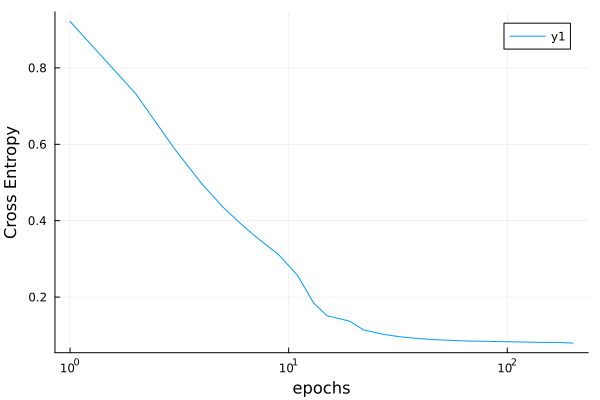

In [10]:
plot(
    curve.parameter_values,
    curve.measurements,
    xlab=curve.parameter_name,
    xscale=curve.parameter_scale,
    ylab = "Cross Entropy",
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*